In [1]:
from collections import defaultdict
import csv
from tqdm import tqdm


## Data Process

In [2]:
def readCSV(path):
    f = open(path, 'rt',encoding='UTF-8')
    c = csv.reader(f)
    header = next(c)
    for l in c:
        d = dict(zip(header,l))
        yield d

In [3]:
def get_feature(path):
    recipe_dict = {}
    for d in tqdm(readCSV(path)):
        recipe_dict[d['id']]= d
    return recipe_dict

In [4]:
import pandas as pd
import numpy as np

r_recipes = pd.read_csv('data/RAW_recipes.csv')
p_recipes = pd.read_csv('data/PP_recipes.csv')

In [5]:
# Using Glove Embeddings

In [6]:
from GetVectorFromGlove import GloveModel

raw_recipe_dict = get_feature("data/RAW_recipes.csv")
raw_feature_list = []
missing = 0
for i in p_recipes.id:
    raw_feature_list.append(raw_recipe_dict[str(i)])

# train_size = int(0.8 * len(p_recipes))
train_size = 8000

train_raw_feature_list = raw_feature_list[:train_size]
calorie_level_train = np.array(p_recipes.calorie_level[:train_size])
# test_raw_feature_list = raw_feature_list[train_size:]
# calorie_level_test = p_recipes.calorie_level[train_size:]

test_raw_feature_list = raw_feature_list[train_size:10000]
calorie_level_test = np.array(p_recipes.calorie_level[train_size:10000])

231637it [00:05, 39310.64it/s]


In [7]:
one_hot_calorie_train = []
one_hot_calorie_test = []
for cal in calorie_level_train:
    one_hot_list = [0, 0, 0]
    one_hot_list[cal] = 1
    one_hot_calorie_train.append(one_hot_list)
for cal in calorie_level_test:
    one_hot_list = [0, 0, 0]
    one_hot_list[cal] = 1
    one_hot_calorie_test.append(one_hot_list)
one_hot_calorie_train = np.array(one_hot_calorie_train)
one_hot_calorie_test = np.array(one_hot_calorie_test)

In [8]:
GM = GloveModel('.\glove.840B.300d.txt')

def update_words_set(words_count, word_list):
    for word in word_list:
        words_count[word] += 1
 
def get_average_vec_from_word_list_list(word_list_list, words_count):
    words_list = []
    
    for ingre in word_list_list:
        words_list.extend(ingre.split(' '))
    update_words_set(words_count, words_list)
    average_word_vector = GM.get_average_vector_of_word_list(words_list)
    return average_word_vector

In [9]:
# Ingredients with Glove

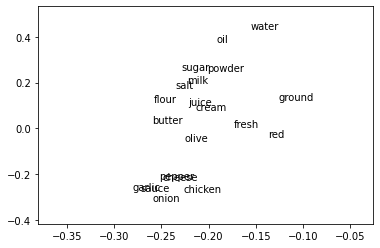

In [10]:
ingredients_words_count = defaultdict(int)

ingredient_vec_train = []
ingredient_vec_test = []
for raw_feature in train_raw_feature_list:
    ingredient_vec_train.append(get_average_vec_from_word_list_list(eval(raw_feature['ingredients']), ingredients_words_count))
for raw_feature in test_raw_feature_list:
    ingredient_vec_test.append(get_average_vec_from_word_list_list(eval(raw_feature['ingredients']), ingredients_words_count))

topk_freq_words = []
for k, v in ingredients_words_count.items():
    topk_freq_words.append((k,v))
topk_freq_words.sort(key=lambda x:x[1], reverse=True)
topk_freq_words = [t[0] for t in topk_freq_words]
GM.get_graph_of_a_word_list(list(topk_freq_words[:20]))

In [11]:

steps_articel_train = []
steps_articel_test = []
for raw_feature in train_raw_feature_list:
    steps_articel_train.append(' '.join(eval(raw_feature['steps'])))
for raw_feature in test_raw_feature_list:
    steps_articel_test.append(' '.join(eval(raw_feature['steps'])))

all_length = []
for s in steps_articel_train:
    all_length.append(len(s.split(' ')))
for s in steps_articel_test:
    all_length.append(len(s.split(' ')))
print(max(all_length))
print(min(all_length))
print(sum(all_length)/len(all_length))
all_length.sort()
half = len(all_length) // 2
print((all_length[half] + all_length[-half])/2)


233
9
90.2786
83.0


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 300)          2424300   
                                                                 
 bidirectional_4 (Bidirectio  (None, 600)              1442400   
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 300)               180300    
                                                                 
 dense_9 (Dense)             (None, 3)                 903       
                                                                 
Total params: 4,047,903
Trainable params: 4,047,903
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
250/250 - 240s - loss: 1.0701 - accuracy: 0.4239 - f1_score: 0.3495 - val_loss: 1.0412 - val_accurac

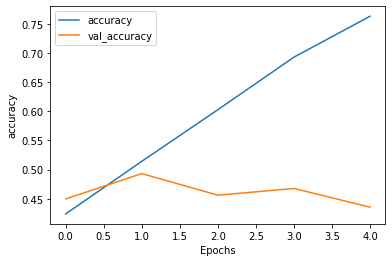

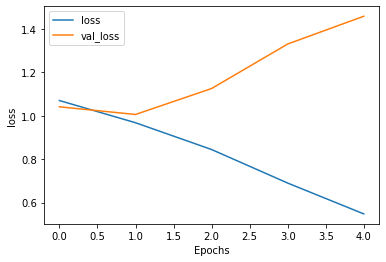

In [16]:
# Steps with Glove and LSTM
from LSTMClassifier import StepsClassifier

SC = StepsClassifier(steps_articel_train, one_hot_calorie_train, steps_articel_test, one_hot_calorie_test, glove_model=GM, max_length=100)
SC.train(num_epochs=5)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 300)          2424300   
                                                                 
 bidirectional_5 (Bidirectio  (None, 600)              1442400   
 nal)                                                            
                                                                 
 dense_10 (Dense)            (None, 300)               180300    
                                                                 
 dense_11 (Dense)            (None, 3)                 903       
                                                                 
Total params: 4,047,903
Trainable params: 4,047,903
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
250/250 - 220s - loss: 1.0626 - accuracy: 0.4218 - f1_score: 0.3651 - val_loss: 1.0496 - val_accurac

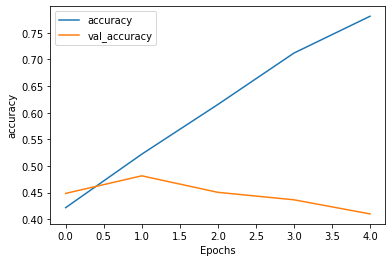

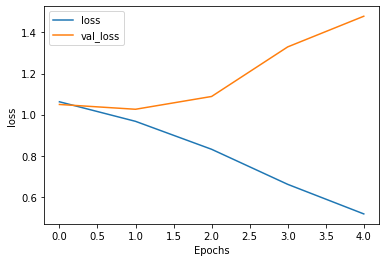

In [17]:
SC = StepsClassifier(steps_articel_train, one_hot_calorie_train, steps_articel_test, one_hot_calorie_test, glove_model=GM, activation='tanh', trainable=True, max_length=100)
SC.train(num_epochs=5)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 9, 300)            2424300   
                                                                 
 bidirectional_6 (Bidirectio  (None, 600)              1442400   
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 300)               180300    
                                                                 
 dense_13 (Dense)            (None, 3)                 903       
                                                                 
Total params: 4,047,903
Trainable params: 4,047,903
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
250/250 - 25s - loss: 1.0705 - accuracy: 0.4207 - f1_score: 0.3406 - val_loss: 1.0632 - val_accuracy

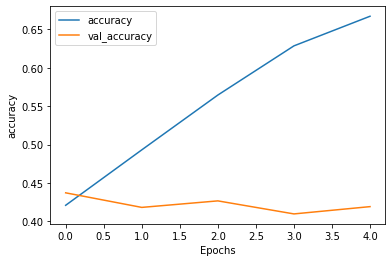

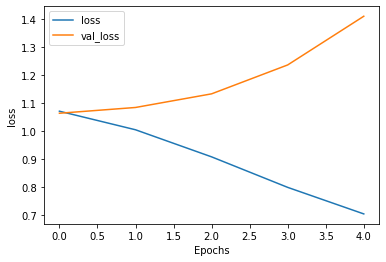

In [18]:
SC = StepsClassifier(steps_articel_train, one_hot_calorie_train, steps_articel_test, one_hot_calorie_test, glove_model=GM, activation='relu', trainable=True, max_length=9)
SC.train(num_epochs=5)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 50, 300)           2424300   
                                                                 
 bidirectional_7 (Bidirectio  (None, 600)              1442400   
 nal)                                                            
                                                                 
 dense_14 (Dense)            (None, 300)               180300    
                                                                 
 dense_15 (Dense)            (None, 3)                 903       
                                                                 
Total params: 4,047,903
Trainable params: 4,047,903
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
250/250 - 96s - loss: 1.0595 - accuracy: 0.4375 - f1_score: 0.3591 - val_loss: 1.0249 - val_accuracy

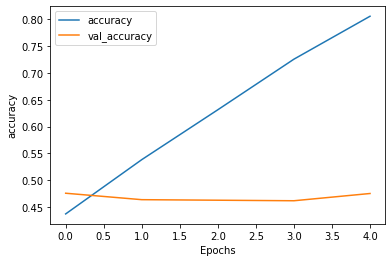

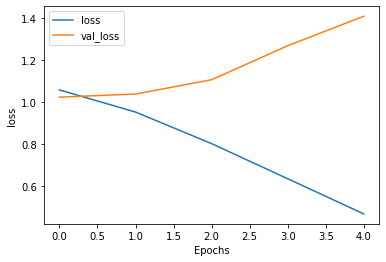

In [19]:
SC = StepsClassifier(steps_articel_train, one_hot_calorie_train, steps_articel_test, one_hot_calorie_test, glove_model=GM, activation='relu', trainable=True, max_length=50)
SC.train(num_epochs=5)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 83, 300)           2424300   
                                                                 
 bidirectional_8 (Bidirectio  (None, 600)              1442400   
 nal)                                                            
                                                                 
 dense_16 (Dense)            (None, 300)               180300    
                                                                 
 dense_17 (Dense)            (None, 3)                 903       
                                                                 
Total params: 4,047,903
Trainable params: 4,047,903
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
250/250 - 167s - loss: 1.0592 - accuracy: 0.4375 - f1_score: 0.3683 - val_loss: 1.0547 - val_accurac

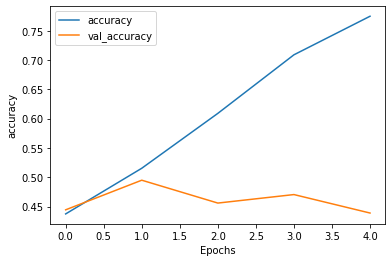

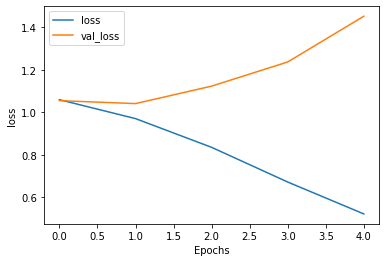

In [20]:
SC = StepsClassifier(steps_articel_train, one_hot_calorie_train, steps_articel_test, one_hot_calorie_test, glove_model=GM, activation='relu', trainable=True, max_length=83)
SC.train(num_epochs=5)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 90, 300)           2424300   
                                                                 
 bidirectional_9 (Bidirectio  (None, 600)              1442400   
 nal)                                                            
                                                                 
 dense_18 (Dense)            (None, 300)               180300    
                                                                 
 dense_19 (Dense)            (None, 3)                 903       
                                                                 
Total params: 4,047,903
Trainable params: 4,047,903
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
250/250 - 184s - loss: 1.0554 - accuracy: 0.4462 - f1_score: 0.3853 - val_loss: 1.0284 - val_accurac

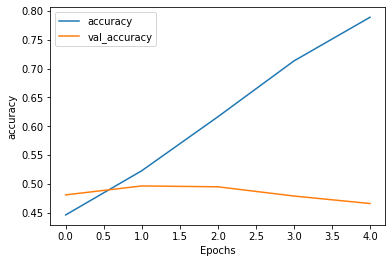

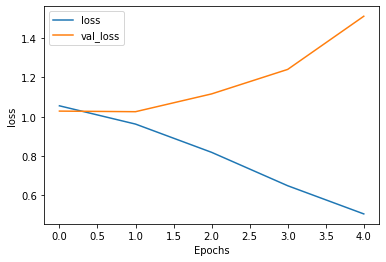

In [21]:
SC = StepsClassifier(steps_articel_train, one_hot_calorie_train, steps_articel_test, one_hot_calorie_test, glove_model=GM, activation='relu', trainable=True, max_length=90)
SC.train(num_epochs=5)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 120, 300)          2424300   
                                                                 
 bidirectional_10 (Bidirecti  (None, 600)              1442400   
 onal)                                                           
                                                                 
 dense_20 (Dense)            (None, 300)               180300    
                                                                 
 dense_21 (Dense)            (None, 3)                 903       
                                                                 
Total params: 4,047,903
Trainable params: 4,047,903
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
250/250 - 254s - loss: 1.0627 - accuracy: 0.4336 - f1_score: 0.3652 - val_loss: 1.0531 - val_accura

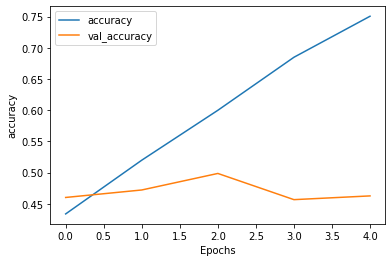

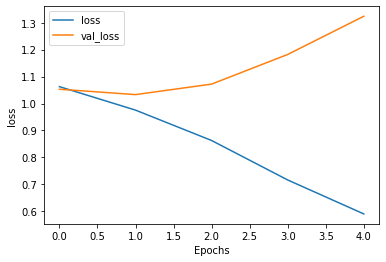

In [22]:
SC = StepsClassifier(steps_articel_train, one_hot_calorie_train, steps_articel_test, one_hot_calorie_test, glove_model=GM, activation='relu', trainable=True, max_length=120)
SC.train(num_epochs=5)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 150, 300)          2424300   
                                                                 
 bidirectional_11 (Bidirecti  (None, 600)              1442400   
 onal)                                                           
                                                                 
 dense_22 (Dense)            (None, 300)               180300    
                                                                 
 dense_23 (Dense)            (None, 3)                 903       
                                                                 
Total params: 4,047,903
Trainable params: 4,047,903
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
250/250 - 344s - loss: 1.0758 - accuracy: 0.4224 - f1_score: 0.3610 - val_loss: 1.0578 - val_accura

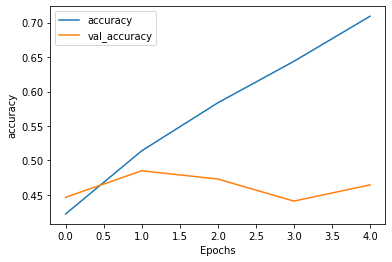

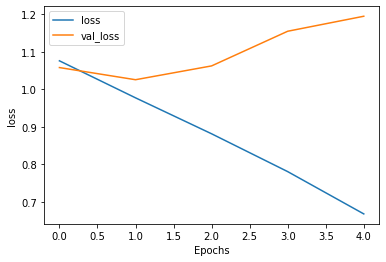

In [23]:
SC = StepsClassifier(steps_articel_train, one_hot_calorie_train, steps_articel_test, one_hot_calorie_test, glove_model=GM, activation='relu', trainable=True, max_length=150)
SC.train(num_epochs=5)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 200, 300)          2424300   
                                                                 
 bidirectional_12 (Bidirecti  (None, 600)              1442400   
 onal)                                                           
                                                                 
 dense_24 (Dense)            (None, 300)               180300    
                                                                 
 dense_25 (Dense)            (None, 3)                 903       
                                                                 
Total params: 4,047,903
Trainable params: 4,047,903
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
250/250 - 507s - loss: 1.0662 - accuracy: 0.4279 - f1_score: 0.3608 - val_loss: 1.0444 - val_accura

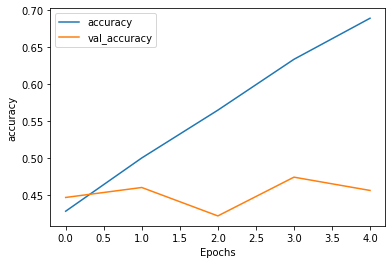

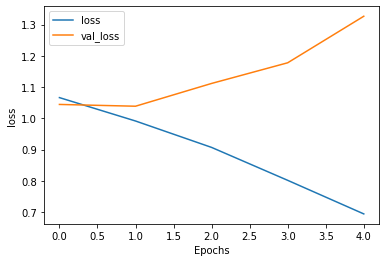

In [24]:
SC = StepsClassifier(steps_articel_train, one_hot_calorie_train, steps_articel_test, one_hot_calorie_test, glove_model=GM, activation='relu', trainable=True, max_length=200)
SC.train(num_epochs=5)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 233, 300)          2424300   
                                                                 
 bidirectional_13 (Bidirecti  (None, 600)              1442400   
 onal)                                                           
                                                                 
 dense_26 (Dense)            (None, 300)               180300    
                                                                 
 dense_27 (Dense)            (None, 3)                 903       
                                                                 
Total params: 4,047,903
Trainable params: 4,047,903
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
250/250 - 662s - loss: 1.0625 - accuracy: 0.4330 - f1_score: 0.3591 - val_loss: 1.0469 - val_accura

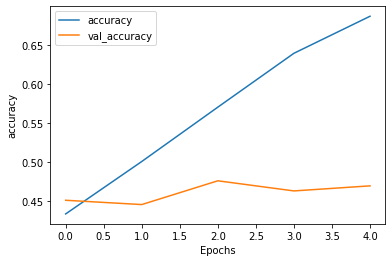

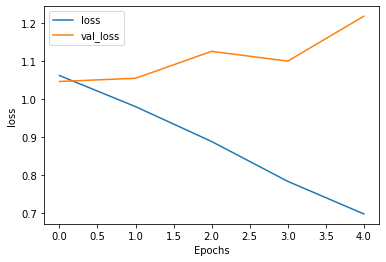

In [25]:
SC = StepsClassifier(steps_articel_train, one_hot_calorie_train, steps_articel_test, one_hot_calorie_test, glove_model=GM, activation='relu', trainable=True, max_length=233)
SC.train(num_epochs=5)

In [ ]:
# Relu notrainabel 300d 200-length - loss: 0.8340 - accuracy: 0.6055 - _f1_m: 1.0455 - val_loss: 0.9081 - val_accuracy: 0.5641 - val__f1_m: 1.0594


In [ ]:
# from tqdm import tqdm

# accuracy, f1 = SC.evaluate_model()
# print('[Evaluation] Accuracy: ', accuracy, ' F1: ', f1)
# print(SC.prediction_single(steps_articel_train[1]))
# res_list = []
# for s in tqdm(steps_articel_test):
#     res_list.append(SC.prediction_single(s))
# acc = 0
# for i in range(len(calorie_level_test)):
#     if int(calorie_level_test[i]) == int(res_list[i]):
#         acc += 1
# print(acc, len(calorie_level_test))
# print(calorie_level_test)
# print(res_list)
